In [1]:
import sys

In [2]:
import scvelo as scv
import scanpy as sc
import cellrank as cr
import numpy as np

scv.settings.verbosity = 3
scv.settings.set_figure_params("scvelo")
cr.settings.verbosity = 2


In [3]:
import warnings
warnings.simplefilter("ignore", category=UserWarning)
warnings.simplefilter("ignore", category=FutureWarning)
warnings.simplefilter("ignore", category=DeprecationWarning)

In [4]:
import os
import pandas as pd
os.getcwd()

'/Volumes/groups/tanaka/People/current/jiwang/projects/heart_regeneration/scripts'

In [5]:
## start to import the data

In [37]:
input_Dir = "../results/sc_multiome_R13591_intron.exon.20220729/FB_EC_Mac_Neu_trajectory_test/"
data_version = 'EC_subtypes.all_timepoints.all_downsample.10k'

In [38]:
data_seuratObj = os.path.join(input_Dir, 
                              "RNAmatrix_umap_kalisto.velocity_spliced_unspliced_" + str(data_version) + ".h5ad")

outDir = input_Dir + str(data_version)
if not os.path.exists(outDir):
   os.makedirs(outDir)


In [39]:
sc.settings.figdir = outDir + '/'
scv.settings.figdir = outDir + '/'

In [40]:
adata = sc.read_h5ad(data_seuratObj, chunk_size=6000)

In [41]:
adata

AnnData object with n_obs × n_vars = 10000 × 16819
    obs: 'orig.ident', 'nCount_ATAC', 'nFeature_ATAC', 'cell_bc', 'condition', 'gex_barcode', 'atac_barcode', 'is_cell', 'atac_raw_reads', 'atac_unmapped_reads', 'atac_lowmapq', 'atac_dup_reads', 'atac_chimeric_reads', 'atac_mitochondrial_reads', 'atac_fragments', 'atac_TSS_fragments', 'atac_peak_region_fragments', 'atac_peak_region_cutsites', 'pct_reads_in_peaks', 'pct_usable_fragments', 'nucleosome_signal', 'nucleosome_percentile', 'TSS.enrichment', 'TSS.percentile', 'nCount_RNA', 'nFeature_RNA', 'iscell_dd_RNA', 'iscell_ed_RNA', 'condition_RNA', 'percent.mt_RNA', 'RNA_snn_res.0.7_RNA', 'seurat_clusters_RNA', 'RNA_snn_res.0.5_RNA', 'subtypes_RNA', 'high.tss', 'subtypes', 'celltypes', 'thegraph_res.1', 'seurat_clusters', 'time', 'cell.ids', 'ATAC_snn_res.0.5', 'clusters', 'cell.id', 'nCount_spliced', 'nFeature_spliced', 'nCount_unspliced', 'nFeature_unspliced'
    var: 'vst.mean', 'vst.variance', 'vst.variance.expected', 'vst.variance

In [42]:
outDir

'../results/sc_multiome_R13591_intron.exon.20220729/FB_EC_Mac_Neu_trajectory_test/EC_subtypes.all_timepoints.all_downsample.10k'

In [43]:
adata.layers.keys()

KeysView(Layers with keys: spliced, unspliced)

In [44]:
adata.obs['condition']= adata.obs['condition'].astype('category') # change the condition into category type
adata.obs['celltypes']= adata.obs['celltypes'].astype('category')
adata.obs['cluster']= adata.obs['seurat_clusters'].astype('category')

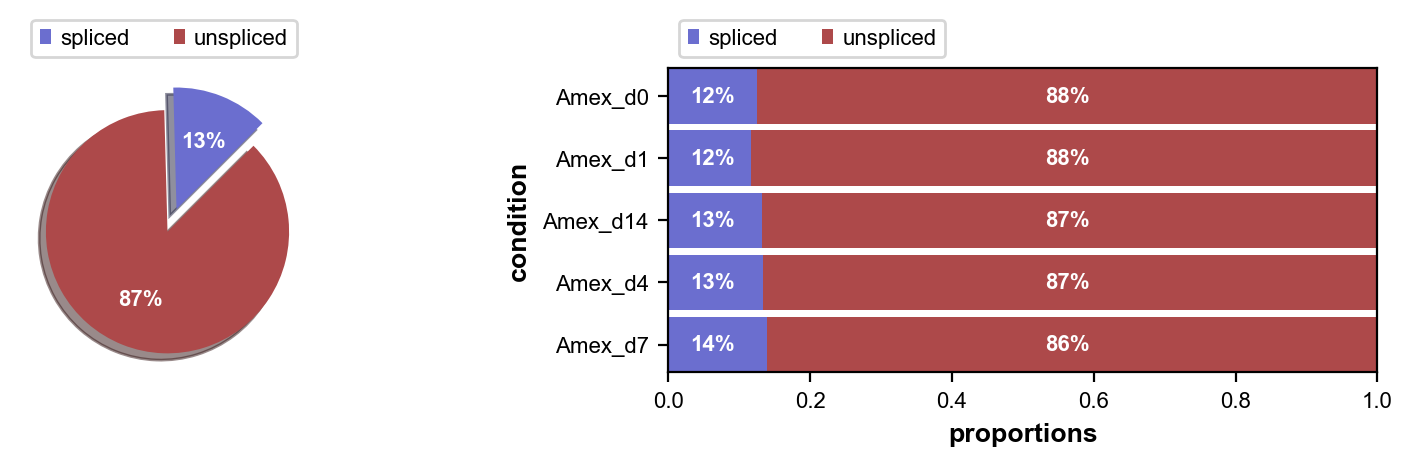

In [45]:
#adata = cr.datasets.pancreas()
scv.pl.proportions(adata, groupby='condition')

In [46]:
parameters = '_topGenes.1000_n.pcs.30_n.neighbors.10'

In [47]:
scv.pp.filter_and_normalize(adata, 
                            min_shared_counts=20, n_top_genes=1000, 
                            flavor = 'seurat', 
                            layers_normalize={'X', 'spliced', 'unspliced'}) # by specifying layers_normalize to renormalize the counts 
#sc.tl.pca(adata)
sc.pp.neighbors(adata, n_pcs=30, n_neighbors=10)
scv.pp.moments(adata, n_pcs=None, n_neighbors=None)

Filtered out 7764 genes that are detected 20 counts (shared).
Normalized count data: X, unspliced, spliced.
Extracted 1000 highly variable genes.
         Falling back to preprocessing with `sc.pp.pca` and default params.
computing moments based on connectivities
    finished (0:00:00) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)


In [48]:
# test diffusion map here
#sc.pp.neighbors(adata, n_neighbors=20, use_rep='X', method='gauss')
#sc.tl.diffmap(adata)
#sc.tl.dpt(adata, n_branchings=1, n_dcs=10)
#adata

In [49]:
#sc.pl.diffmap(adata, color=['dpt_order_indices', 'dpt_groups', 'celltypes'])
outDir

'../results/sc_multiome_R13591_intron.exon.20220729/FB_EC_Mac_Neu_trajectory_test/EC_subtypes.all_timepoints.all_downsample.10k'

In [50]:
sc.tl.paga(adata, groups='celltypes')

/Users/jingkui.wang/anaconda3/envs/cellrank/lib/python3.7/site-packages/networkx/convert.py:157: DeprecationWarning: 

The scipy.sparse array containers will be used instead of matrices
in Networkx 3.0. Use `from_scipy_sparse_array` instead.
  return nx.from_scipy_sparse_matrix(data, create_using=create_using)


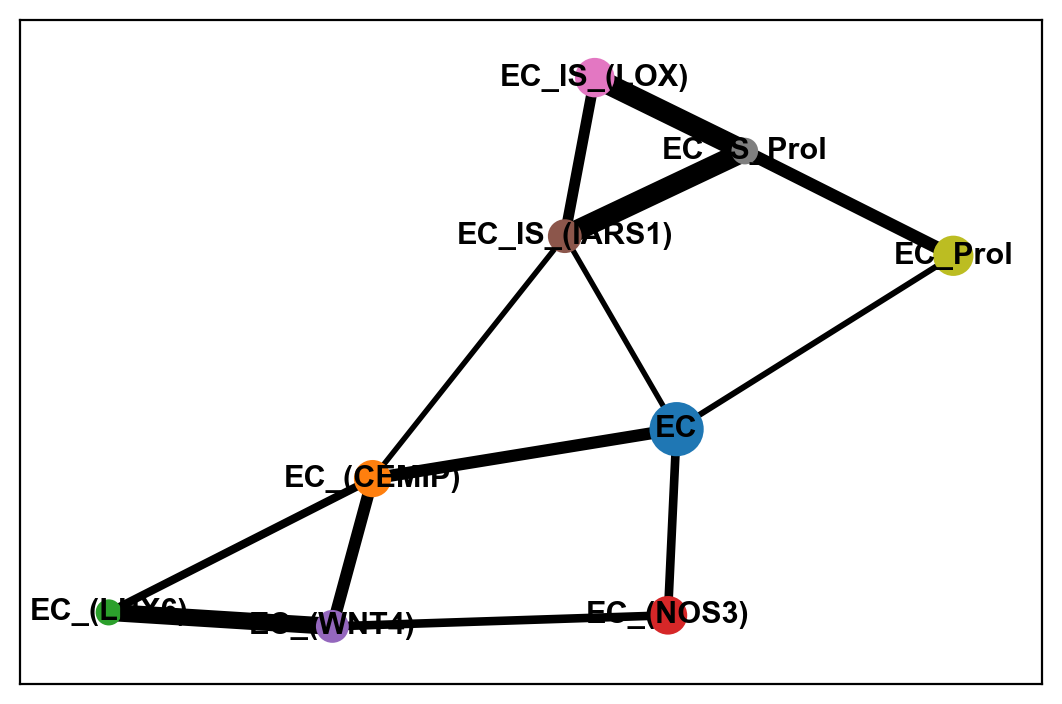

In [51]:
threshold = 0.2
sc.pl.paga(adata, 
           color=['celltypes'], threshold=threshold, show=True,
           save = "PAGA_result_celltypes_threshold." + str(threshold) + '_' + data_version + '.pdf'
        )

In [52]:
scv.tl.recover_dynamics(adata, n_jobs=10, max_iter=10)

recovering dynamics (using 10/10 cores)
    finished (0:00:27) --> added 
    'fit_pars', fitted parameters for splicing dynamics (adata.var)


In [63]:
## here start the RNA velocity
#model = 'dynamical'
model = "steady_state"
model = "stochastic"

In [64]:
scv.tl.velocity(adata, mode=model)
scv.tl.velocity_graph(adata, approx = None, sqrt_transform = None)

computing velocities
    finished (0:00:00) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
computing velocity graph (using 1/10 cores)
    finished (0:00:03) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)


In [65]:
print(adata.var.velocity_genes.sum()) # check the genes used for RNA velocity

201


computing velocity embedding
    finished (0:00:01) --> added
    'velocity_umap', embedded velocity vectors (adata.obsm)
saving figure to file ../results/sc_multiome_R13591_intron.exon.20220729/FB_EC_Mac_Neu_trajectory_test/EC_subtypes.all_timepoints.all_downsample.10k/RNAvelocity_stream_model.stochastic__topGenes.1000_n.pcs.30_n.neighbors.10.pdf


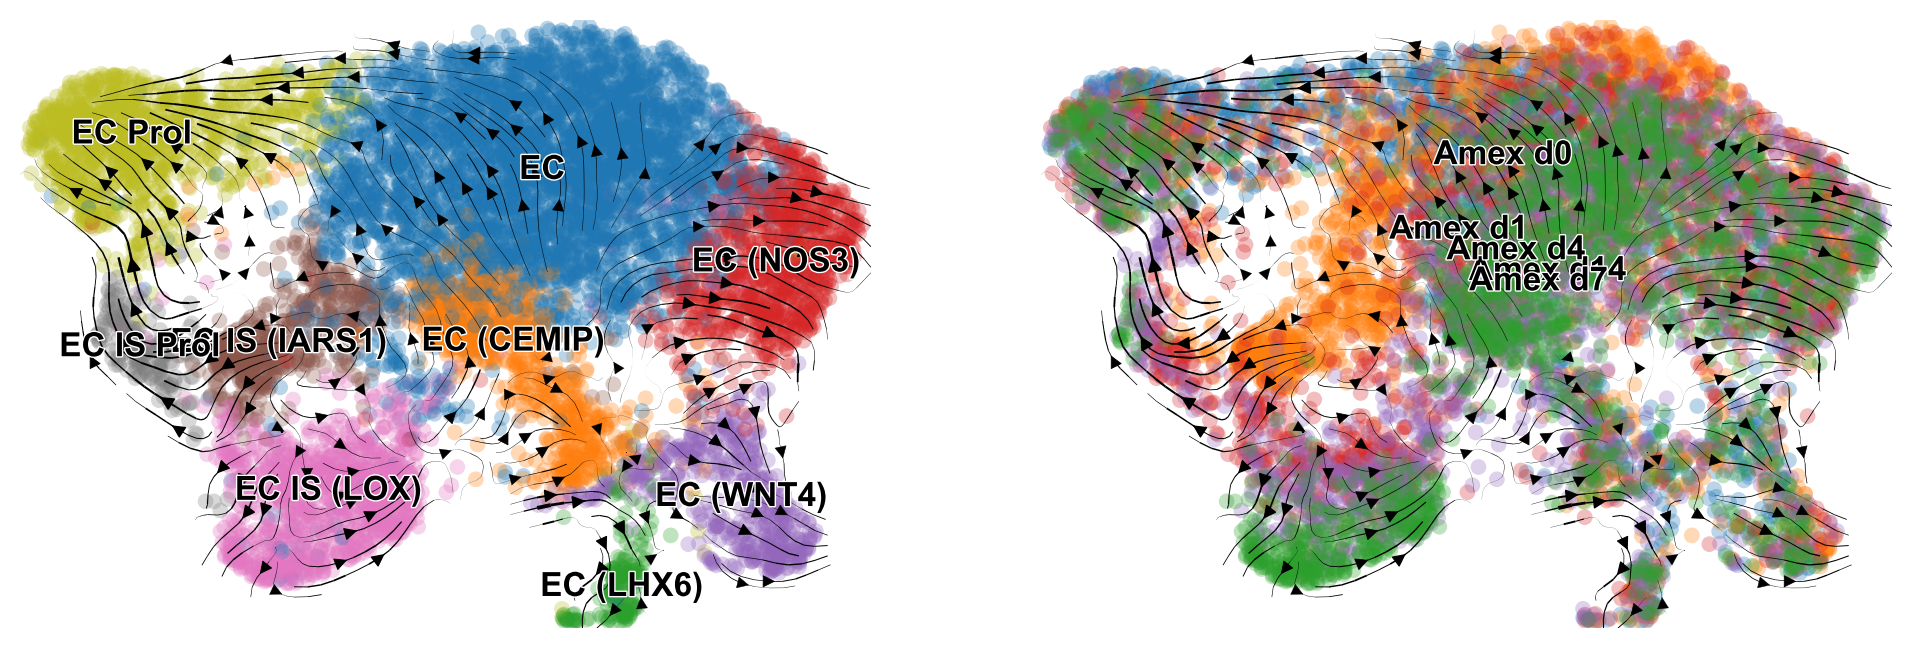

In [66]:
scv.pl.velocity_embedding_stream(
    adata, basis="umap", smooth=0.5, min_mass=1,
    legend_fontsize=12, title="", color = ['celltypes', 'condition'], 
    save=os.path.join(outDir, "RNAvelocity_stream_model." + model + '_' + parameters + ".pdf"))

running PAGA 
    finished (0:00:00) --> added
    'paga/connectivities', connectivities adjacency (adata.uns)
    'paga/connectivities_tree', connectivities subtree (adata.uns)
    'paga/transitions_confidence', velocity transitions (adata.uns)


/Users/jingkui.wang/anaconda3/envs/cellrank/lib/python3.7/site-packages/networkx/convert.py:157: DeprecationWarning: 

The scipy.sparse array containers will be used instead of matrices
in Networkx 3.0. Use `from_scipy_sparse_array` instead.
  return nx.from_scipy_sparse_matrix(data, create_using=create_using)


saving figure to file ../results/sc_multiome_R13591_intron.exon.20220729/FB_EC_Mac_Neu_trajectory_test/EC_subtypes.all_timepoints.all_downsample.10k/scvelo_PAGA_umap_model.stochasticthreshold.0.0_edges.adjusted.pdf


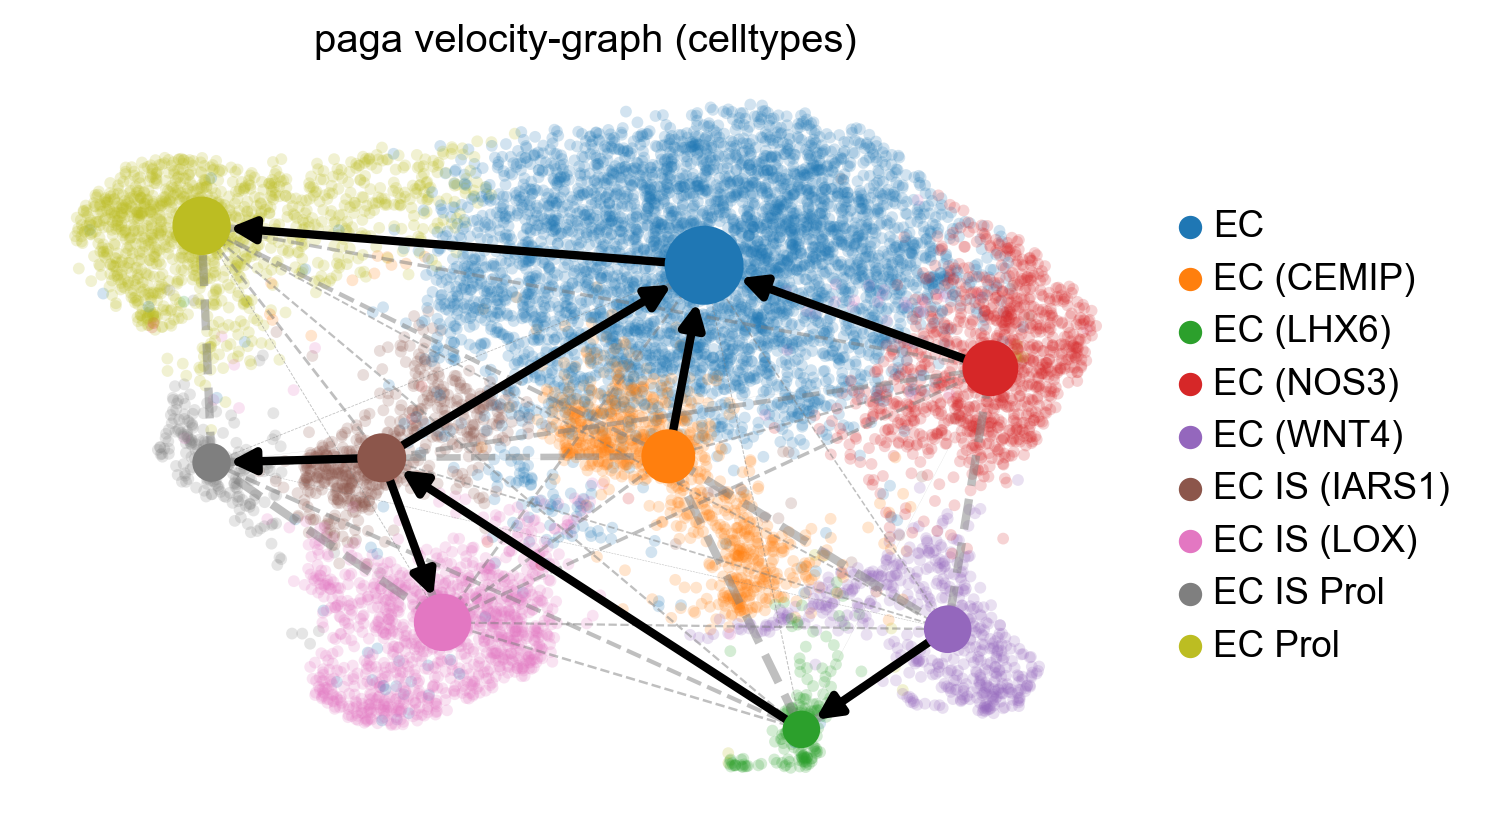

In [67]:
scv.tl.paga(adata, groups='celltypes',
            use_time_prior = None
           )

threshold = 0.
scv.pl.paga(adata, basis='umap', 
            threshold=0.0,
            size=50, 
            alpha=0.2,
            min_edge_width=2.5, 
            node_size_scale=1.5,
            edge_width_scale=1,
            dpi = 120, 
            show=True,
            #dashed_edges = None,
            
            save="PAGA_umap_model." + model + "threshold." +str(threshold) + "_edges.adjusted.pdf"
           )